# Imports

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from time import time
from collections import OrderedDict
from CBFV import composition
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pickle

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, normalize, OrdinalEncoder
from sklearn.model_selection import learning_curve, GridSearchCV, cross_validate, GroupKFold
from sklearn.feature_selection import RFECV, RFE

# Seed

In [2]:
RNG_SEED = 8
np.random.seed(RNG_SEED)
DATA_PATH = os.path.join(os.getcwd(), 'Data')
MODELS_PATH = os.path.join(os.getcwd(), 'Models')
WEIGHTS_PATH = os.path.join(os.getcwd(), 'Weights')
ASSETS_PATH = os.path.join(os.getcwd(), 'Assets')
RESULTS_PATH = os.path.join(os.getcwd(), 'Results')

# Data

## Collection

In [3]:
df_train = pd.read_csv(DATA_PATH + "/intermetallics_train7.csv")
df_val = pd.read_csv(DATA_PATH + "/intermetallics_val7.csv")
df_test = pd.read_csv(DATA_PATH + "/intermetallics_test7.csv")

In [4]:
# remove categorical data and individual atomic fractions that I added  with matminer (except B)
df_train.drop(columns=['composition', 'material_id',
              'structure'], axis=1, inplace=True)

df_val.drop(columns=['composition', 'material_id',
            'structure'], axis=1, inplace=True)

df_test.drop(columns=['composition', 'material_id',
             'structure'], axis=1, inplace=True)

# Gonna train  total_magnetization_ per formula unit so need to remove all other magnetic fields as to not overtrain the data
df_train.drop(['total_magnetization',
              'total_magnetization_normalized_vol'], axis=1, inplace=True)
df_val.drop(['total_magnetization',
            'total_magnetization_normalized_vol'], axis=1, inplace=True)
df_test.drop(['total_magnetization',
             'total_magnetization_normalized_vol'], axis=1, inplace=True)

# save an example of the final traiing dataFrame, so that I can match the order of columns
df_train.to_csv(os.path.join(
    DATA_PATH, 'trainSet_columnOrder.csv'), index=False)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (5872, 1594)
df_val DataFrame shape: (1722, 1594)
df_test DataFrame shape: (844, 1594)


In [5]:
# Need to rename formula_pretty column to formula and total_magnetization_formula_units to target since CBFV needs that
rename_dict = {'total_magnetization_normalized_formula_units': 'target'}
df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

X_train_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(
    df_train, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = composition.generate_features(
    df_val, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = composition.generate_features(
    df_test, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)

columns = X_train_unscaled.columns.values.tolist()


# Scale and Normalize all the numerical training features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

Processing Input Data: 100%|██████████| 5872/5872 [00:00<00:00, 45639.68it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5872/5872 [00:00<00:00, 33811.01it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 1722/1722 [00:00<00:00, 53092.07it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1722/1722 [00:00<00:00, 33719.70it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 844/844 [00:00<00:00, 55486.65it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 844/844 [00:00<00:00, 31004.43it/s]


	Creating Pandas Objects...


In [6]:
# Define some helper functions
def instantiate_model(model_name):
    model = model_name()
    return model


def fit_model(model, X_train, y_train):
    ti = time()
    model = instantiate_model(model)
    model.fit(X_train, y_train)
    fit_time = time() - ti
    return model, fit_time


def evaluate_model(model, X, y_act):
    y_pred = model.predict(X)
    r2 = r2_score(y_act, y_pred)
    mae = mean_absolute_error(y_act, y_pred)
    rmse_val = mean_squared_error(y_act, y_pred, squared=False)
    return r2, mae, rmse_val


def fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_act_val):
    model, fit_time = fit_model(model, X_train, y_train)
    r2_train, mae_train, rmse_train = evaluate_model(model, X_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, X_val, y_act_val)
    result_dict = {
        'model_name': model_name,
        'model_name_pretty': type(model).__name__,
        'model_params': model.get_params(),
        'fit_time': fit_time,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    return model, result_dict


def append_result_df(df, result_dict):
    df_result_appended = df.append(result_dict, ignore_index=True)
    return df_result_appended


def append_model_dict(dic, model_name, model):
    dic[model_name] = model
    return dic


# Build an empty DataFrame to store model results:
df_classics = pd.DataFrame(columns=['model_name',
                                    'model_name_pretty',
                                    'model_params',
                                    'fit_time',
                                    'r2_train',
                                    'mae_train',
                                    'rmse_train',
                                    'r2_val',
                                    'mae_val',
                                    'rmse_val'])
df_classics

# Build a dictionary of model names
classic_model_names = OrderedDict({
    'dumr': DummyRegressor,
    'rr': Ridge,
    'abr': AdaBoostRegressor,
    'gbr': GradientBoostingRegressor,
    'rfr': RandomForestRegressor,
    'etr': ExtraTreesRegressor,
    'svr': SVR,
    'lsvr': LinearSVR,
    'knr': KNeighborsRegressor,
})


# Concatenate the train and validation datasets together
X_train_new = np.concatenate((X_train, X_val), axis=0)
y_train_new = pd.concat((y_train, y_val), axis=0)

print(X_train_new.shape)

(7594, 1746)


In [11]:
#Using K-fold Cross validation to check for overfitting and get a better idea of the errors

# formula group needs to be integers
enc = OrdinalEncoder()

df_train_new =pd.concat((df_train, df_val), axis=0)
enc.fit(df_train_new[["formula","number"]])
df_train_new[["formula","number"]] = enc.transform(df_train_new[["formula","number"]])

groups = df_train_new['formula']
gkf= GroupKFold(n_splits = 5)

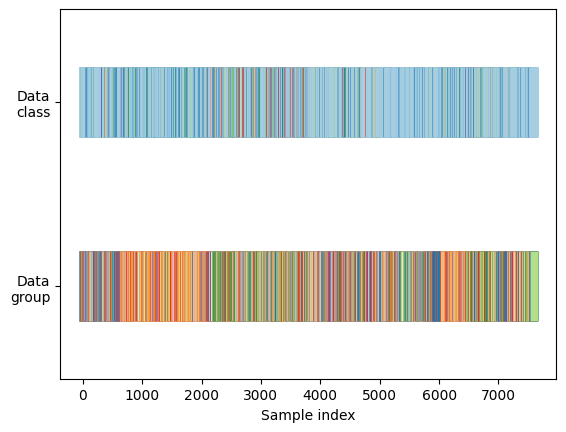

In [12]:
# Visualize data for CV
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def visualize_groups(classes, groups, name):
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )
    return fig


data_vis = visualize_groups(y_train_new, groups, "no groups")

os.path.join(ASSETS_PATH, 'jarvis', 'Data_vis_{}_transparent.png')
data_vis.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Data_vis_{}_transparent.png'),
                        bbox_inches='tight', dpi=600, transparent=True)

data_vis.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Data_vis_{}_.png'),
                        bbox_inches='tight', dpi=600)

In [13]:

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=5):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

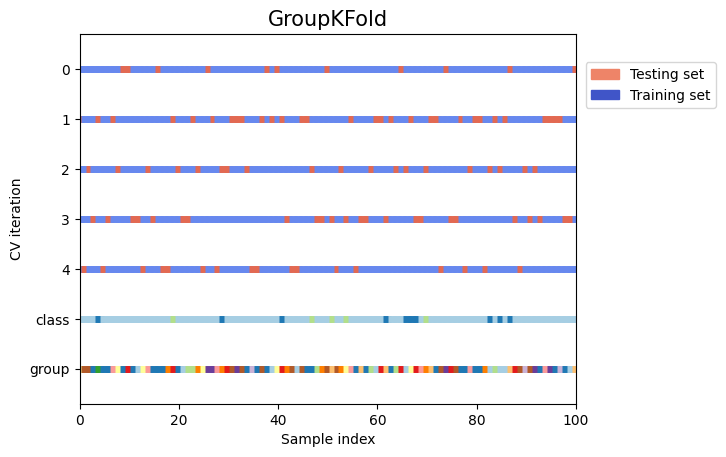

In [14]:
# Plotting CV

fig, ax = plt.subplots()
cv = GroupKFold(n_splits=5)
cv_plot = plot_cv_indices(gkf, df_train_new, y_train_new, groups, ax, 5)

ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc=(1.02, 0.8),
)
cv_plot.figure.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'cv_plot2_{}_transparent.png'), bbox_inches='tight', dpi=600, transparent=True)
cv_plot.figure.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'cv_plot2_{}_.png'), bbox_inches='tight', dpi=600)

# Models

## Extra Trees Regressor

In [ ]:
# new model to make CV fold plots
etr_cv_model = ExtraTreesRegressor(n_estimators=100, criterion='squared_error',
                                   max_features=1.0, verbose=4)

In [ ]:
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

ti = time()

scores = cross_validate(etr_cv_model, X_train_new, y_train_new, groups=groups, verbose=4,
                        scoring=scoring, cv=gkf, return_train_score=True)

etr_cv_model.fit(X_train_new, y_train_new)
dt = time() - ti

print(f'Finished fitting model, total time: {dt:0.2f} s')

In [ ]:
print(scores.keys())

scores_mean = {'r2': np.mean(scores['test_r2']),
               'rmse': np.mean(scores['test_rmse'])}

test_r2 = {'0': scores['test_r2'][0], '1': scores['test_r2'][1], '2': scores['test_r2'][2],
           '3': scores['test_r2'][3], '4': scores['test_r2'][4]}

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10, 10))
plt.plot(range(len(test_r2.keys())),
         test_r2.values(), linestyle='-', marker='o')
plt.xticks(range(len(test_r2)), [str(key) for key in list(test_r2.keys())])
plt.ylim(0.4, 1)
plt.text(0, .6, 'mean $r^2$ = {:0.3f}'.format(scores_mean['r2']), fontsize=20,
         bbox=dict(facecolor='red', alpha=0.3))

plt.xlabel('Cross validation folds')
plt.ylabel('$r^2$')
plt.title('$r^2$ across cross validation folds')

r2_cv = plt.gcf()
r2_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'r2_5-fold_cv_{}_transparent.png'),
              bbox_inches='tight', dpi=600, transparent=True)
r2_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'r2_5-fold_cv_{}_.png'),
              bbox_inches='tight', dpi=600)


test_rmse = {'0': np.negative(scores['test_rmse'][0]), '1': np.negative(scores['test_rmse'])[1],
             '2': np.negative(scores['test_rmse'][2]), '3': np.negative(scores['test_rmse'][3]),
             '4': np.negative(scores['test_rmse'])[4]}

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10, 10))
plt.plot(range(len(test_rmse.keys())), test_rmse.values(),
         linestyle='-', marker='o', color='green')
plt.xticks(range(len(test_rmse)), [str(key) for key in list(test_rmse.keys())])
plt.ylim(2, 3.5)
plt.text(2.5, 2.5, 'mean RMSE = {:0.3f}'.format(np.negative(scores_mean['rmse'])), fontsize=20,
         bbox=dict(facecolor='red', alpha=0.3))

plt.xlabel('Cross validation folds')
plt.ylabel('RMSE ($\u03bc_B$/ f.u.)')
plt.title('RMSE across cross validation folds')

rmse_cv = plt.gcf()

rmse_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'rmse_5-fold_cv_{}_transparent.png'),
                bbox_inches='tight', dpi=600, transparent=True)
rmse_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'rmse_5-fold_cv_{}_.png'),
                bbox_inches='tight', dpi=600)

In [ ]:
train_sizes = [762, 1525, 2287, 3049, 3811, 4573, 5335, 6097, 6859, 7627]

ti = time()
train_sizes, train_scores, validation_scores = learning_curve(etr_cv_model, X_train_new, y_train_new, groups=groups, scoring='r2',cv=gkf, shuffle=True, random_state=RNG_SEED)
dt = time() - ti

# Plotting learning curve
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)


val_scores_mean = validation_scores.mean(axis=1)
val_scores_std = validation_scores.std(axis=1)
print('Mean training scores\n\n', pd.Series(
    train_scores_mean, index=train_sizes))
print('\n', '-' * 20)  # separator
print('\nMean validation scores\n\n', pd.Series(
    val_scores_mean, index=train_sizes))


plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10, 10))
plt.plot(train_sizes, train_scores_mean, label='Training $r^2$')
plt.plot(train_sizes, val_scores_mean, label='Validation $r^2$')
plt.ylabel('r2 score', fontsize=15)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for a linear regression model', fontsize=18, y=1.03)
plt.legend()
# plt.ylim(0,4)

# plt.text(5.5,5,'gap = {:0.3f}'.format(np.negative.difference(train(validation_scores_mean[4])),
#                                    train_scores_mean[4]), fontsize = 20,
#         bbox = dict(facecolor = 'red', alpha = 0.3))

learn_curve = plt.gcf()
learn_curve.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'learn_curve_{}_transparent.png'), bbox_inches='tight', dpi=600, transparent=True)
learn_curve.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'learn_curve_{}_.png'),bbox_inches='tight', dpi=600)

In [ ]:
# Hyperparameter tuning and CV

# Set up hyperparameter tuning grid to be implemented into CV
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}


params_etr = {'n_estimators': [50, 1000], 'max_depth': [50, 100, 1000], 'min_samples_leaf': [
    100, 0.1], 'min_samples_split': [100, 0.1], 'max_features': [1.0, 0.75]}


ti = time()
etr_model = ExtraTreesRegressor(criterion='squared_error')
gs_etr = GridSearchCV(estimator=etr_model, param_grid=params_etr, verbose=4,
                      scoring='neg_root_mean_squared_error', cv=gkf, return_train_score=True, refit=True)

dt = time() - ti
print(f'Finished grid search, total time: {dt:0.2f} s')


ti = time()
gs_etr.fit(X_train_new, y_train_new, groups=groups)
dt = time() - ti

print(f'Finished fitting grid search model, total time: {dt:0.2f} s')

In [ ]:
# Convert results into a DataFrame
gs_results1 = pd.DataFrame(gs_etr.cv_results_)[
    ['params', 'mean_test_score', 'mean_train_score', 'rank_test_score', 'mean_train_score']]
# sort by test scores
gs_results1.sort_values('rank_test_score')

bestIndex = gs_etr.best_index_
mean_rmse_score1 = np.negative(gs_etr.best_score_)

# gs_results1.to_csv(r'C:\Users\joeya\Documents\Fokwa Group\ML_tutorial\intermetallics\tables&lists\magpie\gs_results1.csv', index = False)

In [ ]:
# Second Hyperparameter tuning and CV

# Set up hyperparameter tuning grid to be implemented into CV
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}


# Try with n_estimators = 50 to reduce computational cost and the change it to 1000 in next gs step
params_etr = {'n_estimators': [50], 'min_samples_leaf': [
    1, 25, 50, 100, 200], 'min_samples_split': [2, 25, 50, 100, 200], 'max_features': [1.0]}


ti = time()
etr_model = ExtraTreesRegressor(criterion='squared_error')
gs_etr = GridSearchCV(estimator=etr_model, param_grid=params_etr, verbose=4,
                      scoring='neg_root_mean_squared_error', cv=gkf, return_train_score=True, refit=True)

dt = time() - ti
print(f'Finished grid search, total time: {dt:0.2f} s')


ti = time()
gs_etr.fit(X_train_new, y_train_new, groups=groups)
dt = time() - ti

print(f'Finished fitting grid search model, total time: {dt:0.2f} s')

# Convert results into a DataFrame
gs_results2 = pd.DataFrame(gs_etr.cv_results_)[
    ['params', 'mean_test_score', 'mean_train_score', 'rank_test_score', 'mean_train_score']]
# sort by test scores
gs_results2.sort_values('rank_test_score')

In [ ]:
mean_rmse_score2 = np.negative(gs_etr.best_score_)
# gs_results2.to_csv(r'C:\Users\joeya\Documents\Fokwa Group\ML_tutorial\intermetallics\tables&lists\magpie\gs_results2.csv', index = False)

In [ ]:
# 3rd Hyperparameter tuning and CV

# Set up hyperparameter tuning grid to be implemented into CV
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

# Try with n_estimators = 50 to reduce computational cost and the change it to 1000 in next gs step
params_etr = {'n_estimators': [50], 'min_samples_leaf': [1, 2], 'min_samples_split': [
    2, 3, 4, 5, 6, 7, 9, 10, 15, 20], 'max_features': [1.0]}


ti = time()
etr_model = ExtraTreesRegressor(criterion='squared_error')
gs_etr = GridSearchCV(estimator=etr_model, param_grid=params_etr, verbose=4,
                      scoring='neg_root_mean_squared_error', cv=gkf, return_train_score=True, refit=True)

dt = time() - ti
print(f'Finished grid search, total time: {dt:0.2f} s')


ti = time()
gs_etr.fit(X_train_new, y_train_new, groups=groups)
dt = time() - ti

print(f'Finished fitting grid search model, total time: {dt:0.2f} s')

# Convert results into a DataFrame
gs_results3 = pd.DataFrame(gs_etr.cv_results_)[
    ['params', 'mean_test_score', 'mean_train_score', 'rank_test_score', 'mean_train_score']]
# sort by test scores
gs_results3.sort_values('rank_test_score')

mean_rmse_score = np.negative(gs_etr.best_score_)
# gs_results3.to_csv(r'C:\Users\joeya\Documents\Fokwa Group\ML_tutorial\intermetallics\tables&lists\magpie\gs_results3.csv', index = False)

In [ ]:
# 4th Hyperparameter tuning and CV

# Set up hyperparameter tuning grid to be implemented into CV
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

# Try with n_estimators = 50 to reduce computational cost and the change it to 1000 in next gs step
params_etr = {'n_estimators': [50], 'min_samples_leaf': [1, 2], 'min_samples_split': [
    10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': [1.0]}


ti = time()
etr_model = ExtraTreesRegressor(criterion='squared_error')
gs_etr = GridSearchCV(estimator=etr_model, param_grid=params_etr, verbose=4,
                      scoring='neg_root_mean_squared_error', cv=gkf, return_train_score=True, refit=True)

dt = time() - ti
print(f'Finished grid search, total time: {dt:0.2f} s')


ti = time()
gs_etr.fit(X_train_new, y_train_new, groups=groups)
dt = time() - ti

print(f'Finished fitting grid search model, total time: {dt:0.2f} s')

# Convert results into a DataFrame
gs_results4 = pd.DataFrame(gs_etr.cv_results_)[
    ['params', 'mean_test_score', 'mean_train_score', 'rank_test_score', 'mean_train_score']]
# sort by test scores
gs_results4.sort_values('rank_test_score')

mean_rmse_score = np.negative(gs_etr.best_score_)

gs_results4.to_csv(os.path.join(RESULTS_PATH, 'jarvis',
                   'Set7', 'gs_results4.csv'), index=False)

In [ ]:
# For iteration number 5, optimal min_samples_leaf could be around min_samples_split/3

# Set up hyperparameter tuning grid to be implemented into CV
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

# Try with n_estimators = 50 to reduce computational cost and the change it to 1000 in next gs step
params_etr = {'n_estimators': [50], 'min_samples_leaf': [
    10, 20, 30], 'min_samples_split': [10, 20, 30, 40, 50, 60], 'max_features': [1.0]}


ti = time()
etr_model = ExtraTreesRegressor(criterion='squared_error')
gs_etr = GridSearchCV(estimator=etr_model, param_grid=params_etr, verbose=4,
                      scoring='neg_root_mean_squared_error', cv=gkf, return_train_score=True, refit=True)

dt = time() - ti
print(f'Finished grid search, total time: {dt:0.2f} s')


ti = time()
gs_etr.fit(X_train_new, y_train_new, groups=groups)
dt = time() - ti

print(f'Finished fitting grid search model, total time: {dt:0.2f} s')

# Convert results into a DataFrame
gs_results5 = pd.DataFrame(gs_etr.cv_results_)[
    ['params', 'mean_test_score', 'mean_train_score', 'rank_test_score', 'mean_train_score']]
# sort by test scores
gs_results5.sort_values('rank_test_score')

mean_rmse_score = np.negative(gs_etr.best_score_)
gs_results5.to_csv(os.path.join(RESULTS_PATH, 'jarvis',
                   'Set7', 'gs_results5.csv'), index=False)

In [ ]:
# For iteration number 6, Tuning optimal # of min_samples_leaf with min_samples_split = 40

# Set up hyperparameter tuning grid to be implemented into CV
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

# Try with n_estimators = 50 to reduce computational cost and the change it to 1000 in next gs step
params_etr = {'n_estimators': [50], 'min_samples_leaf': [5, 8, 10, 11, 12, 13, 15,
                                                         16, 17, 18, 19, 20, 23, 25], 'min_samples_split': [40], 'max_features': [1.0], }


ti = time()
etr_model = ExtraTreesRegressor(criterion='squared_error')
gs_etr = GridSearchCV(estimator=etr_model, param_grid=params_etr, verbose=4,
                      scoring='neg_root_mean_squared_error', cv=gkf, return_train_score=True, refit=True)

dt = time() - ti
print(f'Finished grid search, total time: {dt:0.2f} s')


ti = time()
gs_etr.fit(X_train_new, y_train_new, groups=groups)
dt = time() - ti

print(f'Finished fitting grid search model, total time: {dt:0.2f} s')

# Convert results into a DataFrame
gs_results6 = pd.DataFrame(gs_etr.cv_results_)[
    ['params', 'mean_test_score', 'mean_train_score', 'rank_test_score', 'mean_train_score']]
# sort by test scores
gs_results6.sort_values('rank_test_score')

mean_rmse_score = np.negative(gs_etr.best_score_)
gs_results6.to_csv(os.path.join(RESULTS_PATH, 'jarvis',
                   'Set7', 'gs_results6.csv'), index=False)

In [ ]:
# For iteration number 7 tuning min_weight_fraction_leaf

# Set up hyperparameter tuning grid to be implemented into CV
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

# Try with n_estimators = 50 to reduce computational cost and the change it to 1000 in next gs step
params_etr = {'n_estimators': [50], 'min_samples_leaf': [13], 'min_weight_fraction_leaf': [
    0.0, 0.25, 0.5, 0.75, 1.0], 'min_samples_split': [40], 'max_features': [1.0], }


ti = time()
etr_model = ExtraTreesRegressor(criterion='squared_error')
gs_etr = GridSearchCV(estimator=etr_model, param_grid=params_etr, verbose=4,
                      scoring='neg_root_mean_squared_error', cv=gkf, return_train_score=True, refit=True)

dt = time() - ti
print(f'Finished grid search, total time: {dt:0.2f} s')


ti = time()
gs_etr.fit(X_train_new, y_train_new, groups=groups)
dt = time() - ti

print(f'Finished fitting grid search model, total time: {dt:0.2f} s')

# Convert results into a DataFrame
gs_results7 = pd.DataFrame(gs_etr.cv_results_)[
    ['params', 'mean_test_score', 'mean_train_score', 'rank_test_score', 'mean_train_score']]
# sort by test scores
gs_results7.sort_values('rank_test_score')

mean_rmse_score = np.negative(gs_etr.best_score_)

gs_results7.to_csv(os.path.join(RESULTS_PATH, 'jarvis',
                   'Set7', 'gs_results7.csv'), index=False)

In [ ]:
# For iteration number 8 tuning max_features

# Set up hyperparameter tuning grid to be implemented into CV
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

# Try with n_estimators = 50 to reduce computational cost and the change it to 1000 in next gs step
params_etr = {'n_estimators': [50], 'min_samples_leaf': [13], 'min_impurity_decrease': [
    0.0, 0.25, 0.5, 0.75, 1.0], 'min_samples_split': [40], 'max_features': [1.0, 'sqrt', 'log2', 0.8, 0.5, 0.3], }


ti = time()
etr_model = ExtraTreesRegressor(
    criterion='squared_error', random_state=RNG_SEED)
gs_etr = GridSearchCV(estimator=etr_model, param_grid=params_etr, verbose=4,
                      scoring='neg_root_mean_squared_error', cv=gkf, return_train_score=True, refit=True)

dt = time() - ti
print(f'Finished grid search, total time: {dt:0.2f} s')


ti = time()
gs_etr.fit(X_train_new, y_train_new, groups=groups)
dt = time() - ti

print(f'Finished fitting grid search model, total time: {dt:0.2f} s')

# Convert results into a DataFrame
gs_results8 = pd.DataFrame(gs_etr.cv_results_)[
    ['params', 'mean_test_score', 'mean_train_score', 'rank_test_score', 'mean_train_score']]
# sort by test scores
gs_results8.sort_values('rank_test_score')

mean_rmse_score = np.negative(gs_etr.best_score_)

gs_results8.to_csv(os.path.join(RESULTS_PATH, 'jarvis',
                   'Set7', 'gs_results8.csv'), index=False)

In [ ]:
# For iteration number 9 tuning max_features and N_estimators

# Set up hyperparameter tuning grid to be implemented into CV
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

# Try with n_estimators = 50 to reduce computational cost and the change it to 1000 in next gs step
params_etr = {'n_estimators': [50, 100, 500, 1000], 'min_samples_leaf': [
    13], 'min_samples_split': [40], 'max_features': [1.0, 0.8, 0.5, 0.3], }


ti = time()
etr_model = ExtraTreesRegressor(
    criterion='squared_error', random_state=RNG_SEED)
gs_etr = GridSearchCV(estimator=etr_model, param_grid=params_etr, verbose=4,
                      scoring='neg_root_mean_squared_error', cv=gkf, return_train_score=True, refit=True)

dt = time() - ti
print(f'Finished grid search, total time: {dt:0.2f} s')


ti = time()
gs_etr.fit(X_train_new, y_train_new, groups=groups)
dt = time() - ti

print(f'Finished fitting grid search model, total time: {dt:0.2f} s')

# Convert results into a DataFrame
gs_results9 = pd.DataFrame(gs_etr.cv_results_)[
    ['params', 'mean_test_score', 'mean_train_score', 'rank_test_score', 'mean_train_score']]
# sort by test scores
gs_results9.sort_values('rank_test_score')

mean_rmse_score = np.negative(gs_etr.best_score_)

gs_results9.to_csv(os.path.join(RESULTS_PATH, 'jarvis',
                   'Set7', 'gs_results9.csv'), index=False)

In [ ]:
#For iteration number 10 tuning the nodes and splits again

# Set up hyperparameter tuning grid to be implemented into CV
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

#Try with n_estimators = 50 to reduce computational cost and the change it to 1000 in next gs step
params_etr = {'n_estimators':[50], 'min_samples_leaf':[3,4,5,6,7,8,9,10,11,12,13]
               , 'min_samples_split': [5 ,10, 20, 30], 'max_features':[1.0]}


ti = time()
etr_model = ExtraTreesRegressor(criterion='squared_error', random_state=RNG_SEED)
gs_etr = GridSearchCV(estimator=etr_model, param_grid=params_etr,verbose=4,
                    scoring = 'neg_root_mean_squared_error', cv = gkf, return_train_score=True, refit=True)

dt = time() - ti
print(f'Finished grid search, total time: {dt:0.2f} s')


ti = time()
gs_etr.fit(X_train_new, y_train_new,groups=groups)
dt = time() - ti

print(f'Finished fitting grid search model, total time: {dt:0.2f} s')

In [ ]:
# Convert results into a DataFrame
gs_results10 = pd.DataFrame(gs_etr.cv_results_)[
    ['params', 'mean_test_score', 'mean_train_score', 'rank_test_score', 'mean_train_score']]
# sort by test scores
gs_results10.sort_values('rank_test_score')

mean_rmse_score = np.negative(gs_etr.best_score_)

gs_results10.to_csv(os.path.join(RESULTS_PATH, 'jarvis',
                    'Set7', 'gs_results10.csv'), index=False)

In [ ]:
# Check  model learning curve right now
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

etr_model2 = ExtraTreesRegressor(n_estimators=1000, criterion='squared_error',
                                 min_samples_split=10, min_samples_leaf=5, max_features=1.0, verbose=4)

ti = time()
train_sizes, train_scores, validation_scores = learning_curve(etr_model2, X_train_new, y_train_new,
                                                              groups=groups, scoring='r2',
                                                              cv=gkf,
                                                              shuffle=True, random_state=RNG_SEED)
dt = time() - ti

# Plotting learning curve

UNTRIMMED_learn_curve_scores = pd.DataFrame()

UNTRIMMED_learn_curve_scores['train_sizes'] = train_sizes
UNTRIMMED_learn_curve_scores['train_r2'] = train_scores.mean(axis=1)
UNTRIMMED_learn_curve_scores['validaton_r2'] = validation_scores.mean(axis=1)
UNTRIMMED_learn_curve_scores.to_csv(RESULTS_PATH + '/jarvis/UNTRIMMED_learnCurve_rawData.csv', index=False)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)

val_scores_mean = validation_scores.mean(axis=1)
val_scores_std = validation_scores.std(axis=1)
print('Mean training scores\n\n', pd.Series(
    train_scores_mean, index=train_sizes))
print('\n', '-' * 20)  # separator
print('\nMean validation scores\n\n', pd.Series(
    val_scores_mean, index=train_sizes))


plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10, 10))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, val_scores_mean, label='Validation error')
plt.ylabel('r2 score', fontsize=15)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for a linear regression model', fontsize=18, y=1.03)
plt.legend()
# plt.ylim(0,4)

# plt.text(5.5,5,'gap = {:0.3f}'.format(np.negative.difference(train(validation_scores_mean[4])),
#                                    train_scores_mean[4]), fontsize = 20,
#         bbox = dict(facecolor = 'red', alpha = 0.3))

learn_curve = plt.gcf()

In [ ]:
# Check  model learning curve Before feature trimming
train_sizes = np.linspace(0.1, 1.0, 10)

etr_model2 = ExtraTreesRegressor(n_estimators=1000, criterion='squared_error',
                                 min_samples_split=10, min_samples_leaf=5, max_features=1.0, verbose=4)

ti = time()
train_sizes, train_scores, validation_scores = learning_curve(etr_model2, X_train_new, y_train_new,
                                                              groups=groups, scoring='r2',
                                                              cv=gkf,
                                                              shuffle=True, random_state=RNG_SEED)
dt = time() - ti

# Plotting learning curve

UNTRIMMED_learn_curve_scores = pd.DataFrame()

UNTRIMMED_learn_curve_scores['train_sizes'] = train_sizes
UNTRIMMED_learn_curve_scores['train_r2'] = train_scores.mean(axis=1)
UNTRIMMED_learn_curve_scores['validaton_r2'] = validation_scores.mean(axis=1)
UNTRIMMED_learn_curve_scores.to_csv(os.path.join(
    RESULTS_PATH, 'jarvis', 'UNTRIMMED_learnCurve_rawData.csv'), index=False)


train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)

val_scores_mean = validation_scores.mean(axis=1)
val_scores_std = validation_scores.std(axis=1)
print('Mean training scores\n\n', pd.Series(
    train_scores_mean, index=train_sizes))
print('\n', '-' * 20)  # separator
print('\nMean validation scores\n\n', pd.Series(
    val_scores_mean, index=train_sizes))


plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10, 10))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, val_scores_mean, label='Validation error')
plt.ylabel('r2 score', fontsize=15)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for a linear regression model', fontsize=18, y=1.03)
plt.legend()
# plt.ylim(0,4)

# plt.text(5.5,5,'gap = {:0.3f}'.format(np.negative.difference(train(validation_scores_mean[4])),
#                                    train_scores_mean[4]), fontsize = 20,
#         bbox = dict(facecolor = 'red', alpha = 0.3))

learn_curve = plt.gcf()
learn_curve.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'learn_curve2_{}_transparent.png'),bbox_inches='tight', dpi=600, transparent=True)
learn_curve.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'learn_curve2_{}_.png'),
bbox_inches='tight', dpi=600)

In [ ]:
# new model after hyperparameter tuning to make CV fold plots
etr_cv_model = ExtraTreesRegressor(n_estimators=1000, criterion='squared_error',
                                   min_samples_split=10, min_samples_leaf=5, max_features=1.0, verbose=4)

scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

ti = time()

scores = cross_validate(etr_cv_model, X_train_new, y_train_new, groups=groups, verbose=4,
                        scoring=scoring, cv=gkf, return_train_score=True)

etr_cv_model.fit(X_train_new, y_train_new)
dt = time() - ti

print(f'Finished fitting model, total time: {dt:0.2f} s')

print(scores.keys())

In [ ]:
print(scores['test_r2'])
UNTRIMMED_train_scores = pd.DataFrame()
UNTRIMMED_train_scores['test_r2'] = scores['test_r2']
# UNTRIMMED_train_scores_r2.to_csv('C:/Users/joeya/Documents/Fokwa Group/ML_tutorial/Intermetallics/tables&lists/jarvis/UNTRIMMED_test_r2.csv', index=True)

scores_mean = {'r2': np.mean(scores['test_r2']),
               'rmse': np.mean(scores['test_rmse'])}

test_r2 = {'0': scores['test_r2'][0], '1': scores['test_r2'][1], '2': scores['test_r2'][2],
           '3': scores['test_r2'][3], '4': scores['test_r2'][4]}

plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(10, 10))
plt.plot(range(len(test_r2.keys())),
         test_r2.values(), linestyle='-', marker='o')
plt.xticks(range(len(test_r2)), [str(key) for key in list(test_r2.keys())])
plt.ylim(0.7, 1)
plt.text(0, 0.75, 'mean $r^2$ = {:0.3f}'.format(scores_mean['r2']), fontsize=25,
         bbox=dict(facecolor='red', alpha=0.3))

plt.xlabel('Cross validation folds')
plt.ylabel('$r^2$ (arb. units)')
plt.title('$r^2$ across cross validation folds')


r2_cv = plt.gcf()
r2_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                           'tunedModel_UNTRIMMED_r2_5-fold_cv_{}_transparent.png'), bbox_inches='tight', dpi=600, transparent=True)
r2_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7', 'tunedModel_UNTRIMMED_r2_5-fold_cv_{}_.png'),
              bbox_inches='tight', dpi=600)

In [ ]:
test_rmse = {'0': np.negative(scores['test_rmse'][0]), '1': np.negative(scores['test_rmse'])[1],
             '2': np.negative(scores['test_rmse'][2]), '3': np.negative(scores['test_rmse'][3]),
             '4': np.negative(scores['test_rmse'])[4]}

UNTRIMMED_train_scores['test_rmse'] = scores['test_rmse']

plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(10, 10))
plt.plot(range(len(test_rmse.keys())), test_rmse.values(),
         linestyle='-', marker='o', color='green')
plt.xticks(range(len(test_rmse)), [str(key) for key in list(test_rmse.keys())])
plt.ylim(1, 5)
plt.text(0, 2.0, 'mean RMSE = {:0.3f}'.format(np.negative(scores_mean['rmse'])), fontsize=25,
         bbox=dict(facecolor='red', alpha=0.3))

plt.xlabel('Cross validation folds')
plt.ylabel('RMSE ($\u03bc_B$/ f.u.)', fontsize=25)
plt.title('RMSE across cross validation folds')


rmse_cv = plt.gcf()
rmse_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                             'tunedModel_UNTRIMMED_rmse_5-fold_cv_{}_transparent.png'),
                bbox_inches='tight', dpi=600, transparent=True)
rmse_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                             'tunedModel_UNTRIMMED_rmse_5-fold_cv_{}_.png'),
                bbox_inches='tight', dpi=600)

UNTRIMMED_train_scores.to_csv(os.path.join(RESULTS_PATH, 'jarvis', 'Set7',
                                           'UNTRIMMED_test_rawData.csv'), index=False)

In [ ]:
# Save the optimized model
pickle.dump(etr_cv_model, open(os.path.join(
    MODELS_PATH, 'etr7_hyperparameters_tuned.pickle'), 'wb'))

## XGBoost

In [28]:
# New XGBoost model after hyperparameter tuning
xgb.set_config(verbosity=1)

xgb_cv_model = XGBRegressor(learning_rate=0.1, max_depth=6,
                            subsample=0.8, colsample_bytree=1.0, min_child_weight=5)

scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}

ti = time()

scores = cross_validate(xgb_cv_model, X_train_new, y_train_new, groups=groups,
                        verbose=0, scoring=scoring, cv=gkf, return_train_score=True, error_score='raise')

xgb_cv_model.fit(X_train_new, y_train_new, verbose=True)

dt = time() - ti

print(f'Finished fitting model, total time: {dt:0.2f} s')

print(scores.keys())

Finished fitting model, total time: 45.19 s
dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_rmse', 'train_rmse'])


In [29]:
# Print cross-validation scores
print("Cross-validation R-squared scores:", scores['test_r2'])
print("Mean R-squared score:", scores['test_r2'].mean())

# Negated because it's returned as a negative value
print("Cross-validation RMSE scores:", -scores['test_rmse'])
print("Mean RMSE score:", -scores['test_rmse'].mean())

Cross-validation R-squared scores: [0.86703962 0.88714957 0.80340339 0.88239111 0.85485597]
Mean R-squared score: 0.858967933926485
Cross-validation RMSE scores: [3.4139892  2.853421   4.43875718 3.28136419 3.57825711]
Mean RMSE score: 3.5131577342202176


In [30]:
# Assuming you have a separate test set
y_pred = xgb_cv_model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse:.4f}")

R-squared: 0.8477
Root Mean Squared Error: 3.5607


/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Features

In [ ]:
# Getting most important features
pio.renderers.default = 'browser'


importances_list = etr_cv_model.feature_importances_.tolist()
features_list = X_train_unscaled.columns.values.tolist()
featureimportances_dict = dict(zip(features_list, importances_list))
sorted_featureimportances_tuple = sorted(
    featureimportances_dict.items(), key=lambda x: x[1], reverse=True)
sorted_featureimportances_dict = {
    key: value for key, value in sorted_featureimportances_tuple}
sorted_featureimportances_df = pd.DataFrame.from_dict(
    [sorted_featureimportances_dict]).T
sorted_featureimportances_df['Feature'] = sorted_featureimportances_df.index
sorted_featureimportances_df.columns = ['Importance', 'Feature']


sorted_featureimportances_df.to_csv(os.path.join(RESULTS_PATH, 'jarvis', 'Set7',
                                                 'jarvis_feature_importance_table.csv'), index=True)

In [ ]:
# Plotting the most important x features
importances = etr_cv_model.feature_importances_
included = X_train_unscaled.columns.values
indices = np.argsort(importances)[::-1]

fig_bar1 = px.bar(
    x=included[indices][0:20],
    y=importances[indices][0:20],
    title="Feature importances of model",
    labels={"x": "Feature", "y": "Importance"}
)


# fig_bar.show()
plotly.offline.plot(
    fig_bar1, filename=os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
             'jarvis_top_features1.html')

# plotting the least important features
fig_bar2 = px.bar(
    x=included[indices][-20:],
    y=importances[indices][-20:],
    title="Least important features of model",
    labels={"x": "Feature", "y": "Importance"}
)
plotly.offline.plot(
    fig_bar2, filename=os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
             'jarvis_bottom_features1.html'))
    

In [ ]:
# Use RFECV to determine the optimal number of features
etr_estimator = ExtraTreesRegressor(n_estimators=50, criterion='squared_error',
                                    min_samples_split=10, min_samples_leaf=5, max_features=1.0)

rfecv = RFECV(estimator=etr_estimator, step=0.01, cv=gkf, scoring='neg_mean_squared_error',
              min_features_to_select=80, verbose=3)

fit = rfecv.fit(X_train_new, y_train_new, groups=groups)

In [ ]:
# Plotting performance vs number of features:

print("Optimal number of features : %d" % rfecv.n_features_)

n_scores = len(rfecv.cv_results_['mean_test_score'])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel('Mean test neg MSE')
plt.errorbar(
    range(5, n_scores + 5),
    rfecv.cv_results_['mean_test_score'],
    yerr=rfecv.cv_results_['std_test_score']
)
plt.title("Recursive Feature Elimination \nwith correlated features")

rfecv_plot = plt.gcf()
rfecv_plot.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                                'tunedModel_rfecv_plot_transparent.png'),
                   bbox_inches='tight', dpi=600, transparent=True)
rfecv_plot.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                                'tunedModel_rfecv_plot_.png'),
                   bbox_inches='tight', dpi=600)

In [ ]:
# Obsolete
df_features_rfecv = pd.DataFrame(columns=['feature', 'support', 'ranking'])
for i in range(X_train_new.shape[1]):
    row = {'feature': i, 'support': rfecv.support_[
        i], 'ranking': rfecv.ranking_[i]}
    df_features_rfecv = df_features_rfecv.append(row, ignore_index=True)

df_features_rfecv[df_features_rfecv['support'] == True]

selected_features = rfecv.get_support(1)
X_train_rfecv = df[df.columns[selected_features]]

In [ ]:
# Use recursive feature selection class in Sklearn to cut down the number of features.
etr_estimator = ExtraTreesRegressor(n_estimators=100, criterion='squared_error',
                                    min_samples_split=10, min_samples_leaf=6, max_features=1.0)

# define the method
rfe = RFE(estimator=etr_estimator,
          n_features_to_select=91, step=0.01, verbose=4)

# fit the model
rfe.fit(X_train_new, y_train_new)

In [ ]:
# Try cutting down to 11:1 observations:features ratio

# Make a new df with train and val and then featurize it.

df_train_trim = pd.concat([df_train, df_val], ignore_index=True)

# Get the bottom i features and remove them from the the train/val/test dataset
i = 1615
dropped_features = sorted_featureimportances_df['Feature'].tail(
    i).values.tolist()
df_dropped_features = pd.DataFrame(dropped_features)
df_dropped_features.to_csv(os.path.join(RESULTS_PATH, 'jarvis', 'Set7',
                                        'dropped_features.csv'), index=False)

In [ ]:

X_train_trim_unscaled, y_train_trim, formulae_train_new, skipped_train_new = composition.generate_features(
    df_train_trim, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)

X_train_trim_unscaled = X_train_trim_unscaled.drop(
    axis=1, labels=dropped_features)

columns_trim = X_train_trim_unscaled.columns.values.tolist()
df_kept_columns = pd.DataFrame(columns_trim)
df_kept_columns.to_csv(os.path.join(RESULTS_PATH, 'jarvis', 'Set7',
                                    'kept_features.csv'))

In [ ]:

scaler = StandardScaler()

X_train_trim = scaler.fit_transform(X_train_trim_unscaled)

X_train_trim = normalize(X_train_trim)

In [ ]:
# Check model CV performance with previous hyperparameters from all 1700+ features

etr_cv_model2 = ExtraTreesRegressor(n_estimators=1000, criterion='squared_error',
                                    min_samples_split=10, min_samples_leaf=5, max_features=1.0, verbose=4)

scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

ti = time()

scores = cross_validate(etr_cv_model2, X_train_trim, y_train_trim, groups=groups, verbose=4,
                        scoring=scoring, cv=gkf, return_train_score=True)

etr_cv_model2.fit(X_train_trim, y_train_trim)
dt = time() - ti

print(f'Finished fitting model, total time: {dt:0.2f} s')

pickle.dump(etr_cv_model2, open(os.path.join(
    MODELS_PATH, 'etr7_trimmed_hyperparameters_tuned.pickle'), 'wb'))

In [ ]:
print(scores.keys())
TRIMMED_train_scores = pd.DataFrame()
TRIMMED_train_scores['test_r2'] = scores['test_r2']
TRIMMED_train_scores['test_rmse'] = scores['test_rmse']
UNTRIMMED_train_scores.to_csv(os.path.join(
    RESULTS_PATH, 'jarvis', 'TRIMMED_test_rawData.csv'), index=False)

scores_mean = {'r2': np.mean(scores['test_r2']),
               'rmse': np.mean(scores['test_rmse'])}

test_r2 = {'0': scores['test_r2'][0], '1': scores['test_r2'][1], '2': scores['test_r2'][2],
           '3': scores['test_r2'][3], '4': scores['test_r2'][4]}

plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(10, 10))
plt.plot(range(len(test_r2.keys())),
         test_r2.values(), linestyle='-', marker='o')
plt.xticks(range(len(test_r2)), [str(key) for key in list(test_r2.keys())])
plt.ylim(0.7, 1)
plt.text(0, .75, 'mean $r^2$ = {:0.3f}'.format(scores_mean['r2']), fontsize=25,
         bbox=dict(facecolor='red', alpha=0.3))

plt.xlabel('Cross validation folds')
plt.ylabel('$r^2$')
plt.title('$r^2$ across cross validation folds')

r2_cv = plt.gcf()
r2_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                           'tunedModel2_TRIMMED_r2_5-fold_cv_{}_transparent.png'),
              bbox_inches='tight', dpi=600, transparent=True)
r2_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                           'tunedModel2_TRIMMED_r2_5-fold_cv_{}_.png'),
              bbox_inches='tight', dpi=600)


test_rmse = {'0': np.negative(scores['test_rmse'][0]), '1': np.negative(scores['test_rmse'])[1],
             '2': np.negative(scores['test_rmse'][2]), '3': np.negative(scores['test_rmse'][3]),
             '4': np.negative(scores['test_rmse'])[4]}

plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(10, 10))
plt.plot(range(len(test_rmse.keys())), test_rmse.values(),
         linestyle='-', marker='o', color='green')
plt.xticks(range(len(test_rmse)), [str(key) for key in list(test_rmse.keys())])
plt.ylim(1, 5)
plt.text(0.2, 2, 'mean RMSE = {:0.3f}'.format(np.negative(scores_mean['rmse'])), fontsize=25,
         bbox=dict(facecolor='red', alpha=0.3))

plt.xlabel('Cross validation folds')
plt.ylabel('RMSE ($\u03bc_B$/ f.u.)')
plt.title('RMSE across cross validation folds')

rmse_cv = plt.gcf()
rmse_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                             'tunedModel2_TRIMMED_rmse_5-fold_cv_{}_transparent.png'),
                bbox_inches='tight', dpi=600, transparent=True)
rmse_cv.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                             'tunedModel2_TRIMMED_rmse_5-fold_cv_{}_.png'),
                bbox_inches='tight', dpi=600)

In [ ]:
# Set up hyperparameter tuning for TRIMMED model
scoring = {'r2': 'r2',
           'rmse': 'neg_root_mean_squared_error'}

# Try with n_estimators = 50 to reduce computational cost and the change it to 1000 in next gs step
params_etr = {'n_estimators': [50], 'min_samples_leaf': [
    5, 6, 7, 8, 9, 10, 11, 12], 'min_samples_split': [5, 10, 15, 20, 30, 40], }


ti = time()
etr_model2_tune = ExtraTreesRegressor(
    criterion='squared_error', random_state=RNG_SEED)
gs_etr = GridSearchCV(estimator=etr_model2_tune, param_grid=params_etr, verbose=4,
                      scoring='neg_root_mean_squared_error', cv=gkf, return_train_score=True, refit=True)

dt = time() - ti
print(f'Finished grid search, total time: {dt:0.2f} s')


ti = time()
gs_etr.fit(X_train_trim, y_train_trim, groups=groups)
dt = time() - ti

print(f'Finished fitting grid search model, total time: {dt:0.2f} s')

# Convert results into a DataFrame
gs2_results1 = pd.DataFrame(gs_etr.cv_results_)[
    ['params', 'mean_test_score', 'mean_train_score', 'rank_test_score', 'mean_train_score']]
# sort by test scores
gs2_results1.sort_values('rank_test_score')

mean_rmse_score = np.negative(gs_etr.best_score_)

gs2_results1.to_csv(os.path.join(RESULTS_PATH, 'jarvis', 'Set7',
                                 'gs2_results1.csv'), index=False)

In [ ]:
# Learning Curve for TRIMMED model
train_sizes = np.linspace(0.1, 1.0, 10)

etr_model2 = ExtraTreesRegressor(n_estimators=1000, criterion='squared_error',
                                 min_samples_split=10, min_samples_leaf=5, max_features=1.0, verbose=4)


ti = time()
train_sizes, train_scores, validation_scores = learning_curve(etr_model2, X_train_trim, y_train_trim,
                                                              groups=groups, scoring='r2',
                                                              cv=gkf,
                                                              shuffle=True, random_state=RNG_SEED)
dt = time() - ti

In [ ]:
# Plotting learning curve

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)

TRIMMED_learn_curve_scores = pd.DataFrame()

TRIMMED_learn_curve_scores['train_sizes'] = train_sizes
TRIMMED_learn_curve_scores['train_r2'] = train_scores.mean(axis=1)
TRIMMED_learn_curve_scores['validaton_r2'] = validation_scores.mean(axis=1)
TRIMMED_learn_curve_scores.to_csv(os.path.join(RESULTS_PATH, 'jarvis', 'Set7',
                                               'TRIMMED_learnCurve_rawData.csv'), index=False)


val_scores_mean = validation_scores.mean(axis=1)
val_scores_std = validation_scores.std(axis=1)
print('Mean training scores\n\n', pd.Series(
    train_scores_mean, index=train_sizes))
print('\n', '-' * 20)  # separator
print('\nMean validation scores\n\n', pd.Series(
    val_scores_mean, index=train_sizes))


plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(10, 10))
plt.plot(train_sizes, train_scores_mean, label='Training $r^2$')
plt.plot(train_sizes, val_scores_mean, label='Validation $r^2$')
plt.ylabel('r2 score', fontsize=25)
plt.xlabel('Training set size', fontsize=25)
plt.title('Learning curves for a linear regression model', fontsize=25, y=1.03)
plt.legend()
# plt.ylim(0,4)

# plt.text(5.5,5,'gap = {:0.3f}'.format(np.negative.difference(train(validation_scores_mean[4])),
#                                    train_scores_mean[4]), fontsize = 20,
#         bbox = dict(facecolor = 'red', alpha = 0.3))


learn_curve = plt.gcf()
learn_curve.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                                 'learn_curve2_trimmed_transparent.png'),
                    bbox_inches='tight', dpi=600, transparent=True)
learn_curve.savefig(os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                                 'learn_curve2_trimmed_.png'),
                    bbox_inches='tight', dpi=600)

In [ ]:
# Getting most important features

pio.renderers.default = 'browser'


importances_list = etr_cv_model2.feature_importances_.tolist()
features_list = X_train_trim_unscaled.columns.values.tolist()
featureimportances_dict = dict(zip(features_list, importances_list))
sorted_featureimportances_tuple = sorted(
    featureimportances_dict.items(), key=lambda x: x[1], reverse=True)
sorted_featureimportances_dict = {
    key: value for key, value in sorted_featureimportances_tuple}
sorted_featureimportances_df = pd.DataFrame.from_dict(
    [sorted_featureimportances_dict]).T
sorted_featureimportances_df['Feature'] = sorted_featureimportances_df.index
sorted_featureimportances_df.columns = ['Importance', 'Feature']

sorted_featureimportances_df.to_csv(os.path.join(RESULTS_PATH, 'jarvis', 'Set7',
                                                 'jarvis_TRIMMED_feature_importance_table.csv'), index=True)

In [ ]:
# Plotting the most important x features
importances = etr_cv_model2.feature_importances_
included = X_train_trim_unscaled.columns.values
indices = np.argsort(importances)[::-1]

fig_bar1 = px.bar(
    x=included[indices][0:20],
    y=importances[indices][0:20],
    title="Feature importances of model",
    labels={"x": "Feature", "y": "Importance"}
)

# fig_bar.show()
plotly.offline.plot(
    fig_bar1, filename=os.path.join(ASSETS_PATH, 'jarvis', 'Set7',
                                    'jarvis_TRIMMED_top_features1.html'))

# plotting the least important features
fig_bar2 = px.bar(
    x=included[indices][-20:],
    y=importances[indices][-20:],
    title="Least important features of model",
    labels={"x": "Feature", "y": "Importance"}
)
plotly.offline.plot(
    fig_bar2, filename=ASSETS_PATH + '/jarvis/Set7/jarvis_TRIMMED_bottom_features1.html')